In [3]:
import os

import nltk

from cltk.corpus.latin import latinlibrary

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

import matplotlib.pyplot as plt

import pickle

from pprint import pprint

In [4]:
Lemmatizer = pickle.load(open("./tools/lemmatizer.p", "rb"))

In [6]:
TextArray = pickle.load(open("./data/text_array.p", "rb"))

In [7]:
print(f'{TextArray[1][0]},\n{TextArray[1][1]},\n{TextArray[1][2][:1000]}')

prose,
caesar/bc1.txt,
gratiam sequantur ut superioribus fecerint temporibus se sibi consilium capturum neque senatus auctoritati obtemperaturum habere se quoque ad caesaris gratiam atque amicitiam receptum in eandem sententiam loquitur scipio pompeio esse in animo rei publicae non deesse si senatus sequatur si cunctetur atque agat lenius nequiquam eius auxilium si postea uelit senatum imploraturum
haec scipionis oratio quod senatus in urbe habebatur pompeiusque aberat ex ipsius ore pompei mitti uidebatur dixerat aliquis leniorem sententiam ut primo m marcellus ingressus in eam orationem non oportere ante de ea re ad senatum referri quam dilectus tota italia habiti et exercitus conscripti essent quo praesidio tuto et libere senatus quae uellet decernere auderet ut m calidius qui censebat ut pompeius in suas prouincias proficisceretur ne qua esset armorum causa timere caesarem ereptis ab eo duabus legionibus ne ad eius periculum reseruare et retinere eas ad urbem pompeius uideretur ut m

In [46]:
def get_lemmatized_text(text):
    tokens = text.split()
    lemma_list = Lemmatizer.lemmatize(tokens)
    lemmas = [lemma[1] for lemma in lemma_list]
    return " ".join(lemmas).replace('1','').replace('2','')

In [47]:
labels = [type for type, _, _ in TextArray]
texts = [get_lemmatized_text(text) for _, _, text in TextArray]
titles = [title.replace('/', '_').replace('.txt','') for _, title, _ in TextArray]

In [48]:
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(texts)
vocab = np.array(vectorizer.get_feature_names())
dtm = dtm.toarray()

In [49]:
dtm

array([[ 89,   0,   0, ...,   0,   0,   0],
       [151,   0,   0, ...,   0,   0,   0],
       [ 64,   0,   0, ...,   0,   0,   0],
       ...,
       [ 18,   0,   0, ...,   0,   0,   0],
       [ 23,   0,   0, ...,   0,   0,   0],
       [ 24,   0,   0, ...,   0,   0,   0]], dtype=int64)

In [50]:
dtm.shape

(137, 28504)

In [51]:
text_array_df = pd.DataFrame(dtm, columns=vocab, index=titles)
text_array_df.iloc[[0,25,50,100,123],:10]

,ab,abacorum,abacus,abalieno,abantem,abantiades,abantis,abarimque,abarin,abas
caesar_alex,89,0,0,0,0,0,0,0,0,0
livy_liv.24,168,0,0,0,0,0,0,0,0,0
vergil_aen11,16,0,0,0,0,0,0,0,0,0
ovid_ovid.her19,5,0,0,0,0,0,0,0,0,0
ovid_ovid.met6,23,0,0,0,0,0,0,0,0,0


In [52]:
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)

In [53]:
rates_df = pd.DataFrame(rates, columns=vocab, index=titles)
rates_df.iloc[[0,25,50,100,125,136],:10]

,ab,abacorum,abacus,abalieno,abantem,abantiades,abantis,abarimque,abarin,abas
caesar_alex,8.692255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
livy_liv.24,12.105491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vergil_aen11,2.820377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ovid_ovid.her19,4.512635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ovid_ovid.met8,5.414488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ovid_ovid.tristia5,5.159071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
prose_indices, verse_indices = [], []

for i, item in enumerate(TextArray):
    if item[0] == "prose":
        prose_indices.append(i)
    elif item[0] == "verse":
        verse_indices.append(i)

In [55]:
from sklearn.feature_selection import chi2
keyness, _ = chi2(dtm, labels)
ranking = np.argsort(keyness)[::-1]

In [56]:
ranking[0:10]

array([13640, 21598, 12499, 24811,   359,  9142,  6723,     0,  9389,
        2784])

In [57]:
vocab[ranking][0:10]

array(['is', 'qui', 'in', 'sum', 'ad', 'et', 'cum', 'ab', 'ex', 'atque'],
      dtype='<U22')

In [58]:
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

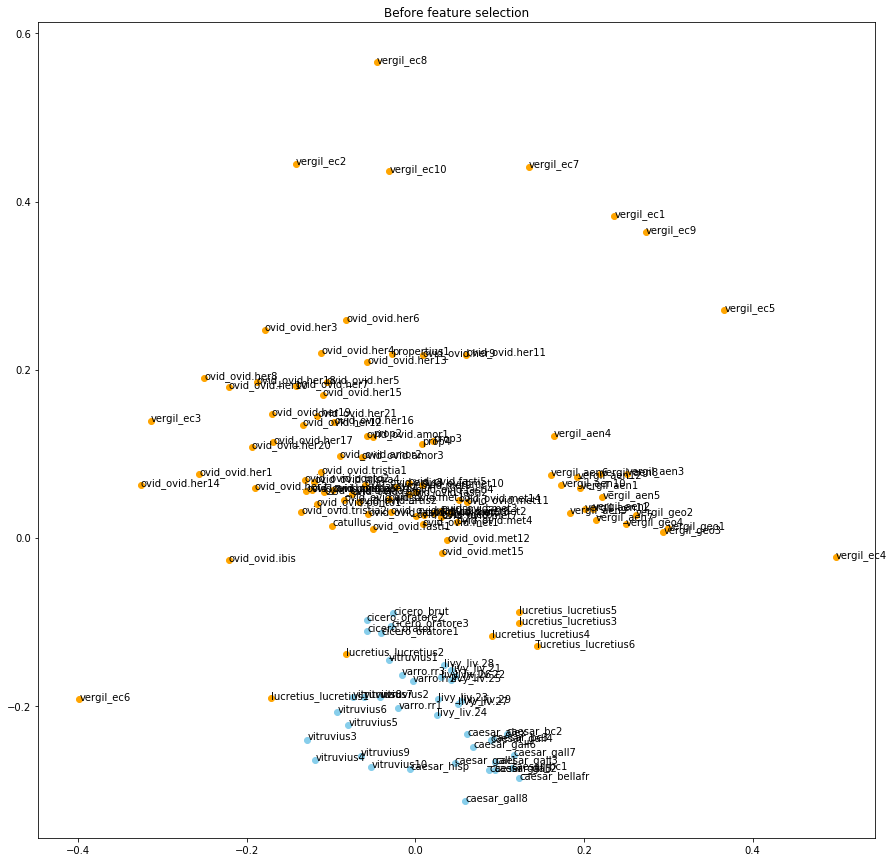

In [59]:
xs, ys = pos[:, 0], pos[:, 1]

names = [os.path.basename(fn).replace('.txt', '') for fn in titles]

plt.figure(figsize=(15,15))
for x, y, title, label in zip(xs, ys, titles, labels):
    color = 'orange' if label == 'verse' else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, title)


plt.title("Before feature selection")
plt.show()

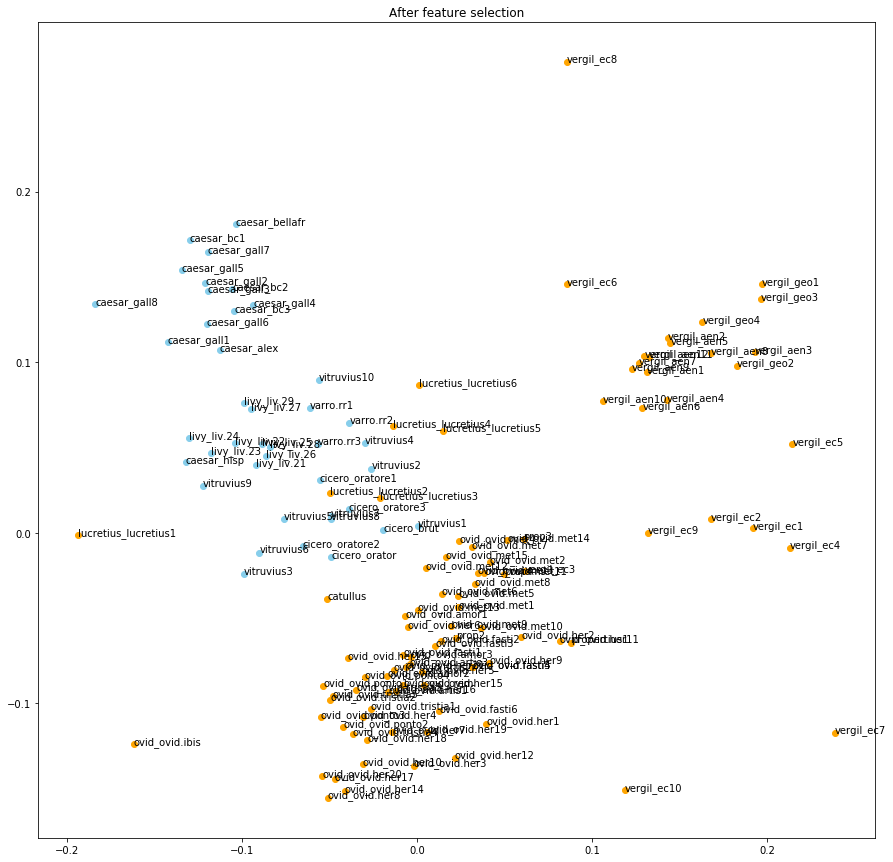

In [60]:
selected = np.argsort(keyness)[::-1][:50]
dtm_chi2 = dtm[:, selected]
dist = 1 - cosine_similarity(dtm_chi2)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

plt.figure(figsize=(15,15))
for x, y, title, label in zip(xs, ys, titles, labels):
    color = 'orange' if label == 'verse' else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, title)

plt.title("After feature selection")
plt.show()

In [61]:
text_array_df.iloc[:10,selected[:10]]

,is,qui,in,sum,ad,et,cum,ab,ex,atque
caesar_alex,194,313,260,257,136,205,139,89,86,110
caesar_bc1,206,318,242,196,166,203,104,151,104,179
caesar_bc2,97,180,129,123,98,120,53,64,84,87
caesar_bc3,315,397,284,354,243,338,158,176,173,192
caesar_bellafr,260,296,329,245,177,285,203,181,120,158
caesar_gall1,276,277,176,223,110,191,88,102,58,73
caesar_gall2,94,123,108,86,67,87,55,62,43,57
caesar_gall3,74,112,82,73,49,65,42,30,36,58
caesar_gall4,106,172,113,111,81,118,53,48,50,70
caesar_gall5,170,193,180,152,133,132,97,89,84,105


In [62]:
text_array_df.iloc[-10:,selected[:10]]

,is,qui,in,sum,ad,et,cum,ab,ex,atque
ovid_ovid.ponto1,12,117,61,187,24,76,42,27,8,3
ovid_ovid.ponto2,8,105,52,225,19,86,33,32,0,8
ovid_ovid.ponto3,12,95,55,192,27,65,29,27,7,3
ovid_ovid.ponto4,10,141,74,248,29,117,34,33,6,10
ovid_ovid.rem,5,101,66,221,20,127,25,17,7,5
ovid_ovid.tristia1,9,85,68,194,12,83,18,30,5,3
ovid_ovid.tristia2,9,74,43,136,7,55,23,16,2,3
ovid_ovid.tristia3,17,101,81,207,12,90,26,18,8,6
ovid_ovid.tristia4,5,96,58,208,12,77,28,23,5,3
ovid_ovid.tristia5,4,122,74,198,15,78,32,24,3,10


In [63]:
text_array_df.iloc[:10,selected[-10:]]

,eques,itaque,possum,pars,dies,nauis,hannibal,copia,orator,reliquus
caesar_alex,12,18,62,60,21,76,0,36,0,27
caesar_bc1,35,13,51,38,53,39,0,24,0,42
caesar_bc2,22,11,38,22,18,45,0,21,0,18
caesar_bc3,43,17,75,49,69,84,0,37,0,56
caesar_bellafr,84,29,44,55,47,60,0,91,0,34
caesar_gall1,11,6,63,25,37,2,0,28,0,20
caesar_gall2,9,2,33,25,8,0,0,14,0,17
caesar_gall3,4,6,21,17,7,28,0,11,0,16
caesar_gall4,15,7,32,32,21,35,0,8,1,22
caesar_gall5,22,7,44,45,38,26,0,25,0,17


In [64]:
text_array_df.iloc[-10:,selected[-10:]]

,eques,itaque,possum,pars,dies,nauis,hannibal,copia,orator,reliquus
ovid_ovid.ponto1,1,0,32,14,3,2,0,0,1,1
ovid_ovid.ponto2,0,0,30,11,6,3,0,1,0,0
ovid_ovid.ponto3,0,0,28,12,1,2,0,2,0,1
ovid_ovid.ponto4,2,0,36,18,9,3,0,2,0,0
ovid_ovid.rem,0,0,44,12,3,4,0,1,0,0
ovid_ovid.tristia1,0,0,25,10,3,2,0,1,0,1
ovid_ovid.tristia2,3,0,22,16,3,0,0,0,0,0
ovid_ovid.tristia3,0,0,36,13,2,1,0,0,0,0
ovid_ovid.tristia4,2,0,16,12,6,2,0,0,0,0
ovid_ovid.tristia5,0,0,31,20,9,3,0,0,0,0


In [71]:
text_array_df.loc[:,['uxor','coniunx']][:10]

,uxor,coniunx
caesar_alex,0,0
caesar_bc1,0,0
caesar_bc2,1,0
caesar_bc3,1,0
caesar_bellafr,0,3
caesar_gall1,2,0
caesar_gall2,0,0
caesar_gall3,0,0
caesar_gall4,1,0
caesar_gall5,1,0


In [72]:
text_array_df.loc[:,['uxor','coniunx']][-10:]

,uxor,coniunx
ovid_ovid.ponto1,1,5
ovid_ovid.ponto2,1,2
ovid_ovid.ponto3,5,5
ovid_ovid.ponto4,0,2
ovid_ovid.rem,2,7
ovid_ovid.tristia1,5,4
ovid_ovid.tristia2,1,1
ovid_ovid.tristia3,0,6
ovid_ovid.tristia4,3,7
ovid_ovid.tristia5,1,5


In [73]:
prose_index = [i for i, item in enumerate(TextArray) if item[0] == 'prose']
verse_index = [i for i, item in enumerate(TextArray) if item[0] == 'verse']

In [74]:
p_sum = text_array_df.iloc[prose_index].sum().tolist()
v_sum = text_array_df.iloc[verse_index].sum().tolist()

In [75]:
type_df = pd.DataFrame(list(zip(p_sum, v_sum)), columns = ['prose', 'verse'], index=vocab)

In [76]:
type_df['poeticness'] = type_df['verse'] / (type_df['prose'] + type_df['verse'])

In [77]:
from sklearn.preprocessing import minmax_scale
type_df['keyness_scaled'] = minmax_scale(keyness)

In [78]:
type_df.sort_values(['keyness_scaled'], ascending=[0])[:10]

,prose,verse,poeticness,keyness_scaled
is,8727,743,0.078458,1.000000
qui,12819,6697,0.343154,0.680482
in,11424,5413,0.321494,0.660348
sum,14869,10154,0.405787,0.593617
ad,6188,1644,0.209908,0.514530
et,11917,9548,0.444817,0.383358
cum,5345,2239,0.295227,0.340077
ab,4352,1567,0.264741,0.306824
ex,3208,651,0.168697,0.297881
atque,3954,1420,0.264235,0.279219


In [79]:
type_df.loc['coniunx']

prose              23.000000
verse             329.000000
poeticness          0.934659
keyness_scaled      0.005253
Name: coniunx, dtype: float64

In [80]:
type_df.loc['uxor']

prose             32.000000
verse             64.000000
poeticness         0.666667
keyness_scaled     0.000030
Name: uxor, dtype: float64

In [82]:
type_df.loc['is']

prose             8727.000000
verse              743.000000
poeticness           0.078458
keyness_scaled       1.000000
Name: is, dtype: float64

In [84]:
type_df.loc['et']

prose             11917.000000
verse              9548.000000
poeticness            0.444817
keyness_scaled        0.383358
Name: et, dtype: float64

## Mapping 'poeticness' in narrative space

In [85]:
# Script for preprocessing texts

import html
import re
import string
from cltk.stem.latin.j_v import JVReplacer

def preprocess(text):
    
    replacer = JVReplacer()
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
        
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j    
    
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
    
    return text.strip()

In [88]:
odes_tokens = get_lemmatized_text(preprocess("""Ne forte credas interitura quae
longe sonantem natus ad Aufidum
non ante volgatas per artis
verba loquor socianda chordis:
non, si priores Maeonius tenet
sedes Homerus, Pindaricae latent
Ceaeque et Alcaei minaces
Stesichorique graves Camenae

nec siquid olim lusit Anacreon
delevit aetas; spirat adhuc amor
vivuntque conmissi calores
Aeoliae fidibus puellae.

non sola comptos arsit adulteri
crinis et aurum vestibus inlitum
mirata regalisque cultus
et comites Helene Lacaena

primusve Teucer tela Cydonio
direxit arcu; non semel Ilios
vexata; non pugnavit ingens
Idomeneus Sthenelusve solus

dicenda Musis proelia; non ferox
Hector vel acer Deiphobus gravis
excepit ictus pro pudicis
coniugibus puerisque primus.

vixere fortes ante Agamemnona
multi; sed omnes inlacrimabiles
urgentur ignotique longa
nocte, carent quia vate sacro.

paullum sepultae distat inertiae
celata virtus. non ego te meis
chartis inornatum silebo,
totve tuos patiar labores

inpune, Lolli, carpere lividas
obliviones. est animus tibi
rerumque prudens et secundis
temporibus dubiisque rectus,

vindex avarae fraudis et abstinens
ducentis ad se cuncta pecuniae,
consulque non unius anni,
sed quotiens bonus atque fidus
iudex honestum praetulit utili,
reiecit alto dona nocentium
voltu, per obstantis catervas
explicuit sua victor arma.

non possidentem multa vocaveris
recte beatum; rectius occupat
nomen beati qui deorum
muneribus sapienter uti

duramque callet pauperiem pati
peiusque leto flagitium timet,
non ille pro caris amicis
aut patria timidus perire.""")).split()

In [89]:
print(odes_tokens[:100])

['ne', 'fors', 'credo', 'intereo', 'qui', 'longus', 'sono', 'nascor', 'ad', 'aufidum', 'non', 'ante', 'uolgatas', 'per', 'ars', 'uerbum', 'loquor', 'socio', 'chordus', 'non', 'si', 'prior', 'maeonius', 'teneo', 'sedes', 'homerus', 'pindaricae', 'lateo', 'ceaeque', 'et', 'alcaei', 'minax', 'stesichorique', 'grauis', 'camenae', 'neque', 'siquis', 'olim', 'ludo', 'anacreon', 'deleo', 'aetas', 'spiro', 'adhuc', 'amor', 'uiuuntque', 'con-mitto', 'calor', 'aeoliae', 'fides', 'puella', 'non', 'solus', 'como', 'ardeo', 'adulter', 'crinis', 'et', 'aurum', 'uestis', 'illitus', 'miro', 'regales', 'cultus', 'et', 'comes', 'helene', 'lacaena', 'primusue', 'teucer', 'telum', 'cydonius', 'dirigo', 'arcus', 'non', 'semel', 'ilios', 'vexo', 'non', 'pugno', 'ingens', 'idomeneus', 'sthenelusue', 'solus', 'dico', 'musis', 'proelio', 'non', 'ferox', 'hector', 'uel', 'acer', 'deiphobus', 'grauis', 'excipio', 'iacio', 'pro', 'pudicus', 'conjunx', 'puer']


In [90]:
odes_score = []

for token in odes_tokens:
    if token in vocab:
        odes_score.append(type_df.loc[token][2]-.5)
    else:
        odes_score.append(0)

print(odes_score[:25])

[-0.17093023255813955, 0.1775147928994083, 0.1826625386996904, 0.00666666666666671, -0.1568456650953064, 0.0725255972696246, 0.32727272727272727, 0.1300448430493274, -0.2900919305413687, -0.5, -0.07527333894028593, -0.016129032258064502, 0, 0.07235421166306699, -0.05804195804195805, -0.04142581888246627, 0.04658385093167705, 0.20833333333333337, 0.09999999999999998, -0.07527333894028593, -0.060390295358649815, 0.008503401360544172, 0, 0.11859582542694502, 0.2845303867403315]


In [91]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [92]:
odes_score_running = running_mean(odes_score, 25)

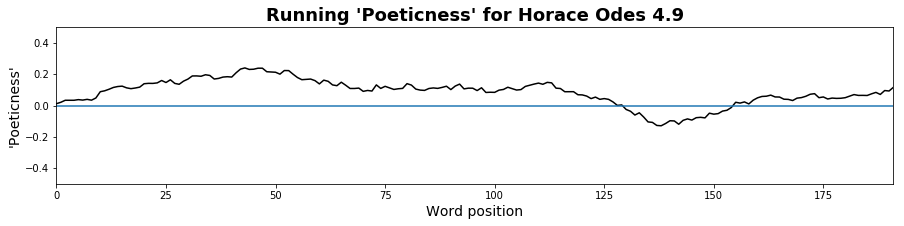

In [93]:
fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(odes_score_running, color="k")

t =  plt.title('Running \'Poeticness\' for Horace Odes 4.9',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)
ax.set_xlim(0,len(odes_score_running)-1)

ax.set_xlabel('Word position', fontsize = 14)
ax.set_ylabel('\'Poeticness\'', fontsize = 14)
plt.show()

In [94]:
list(odes_score_running).index(min(odes_score_running))
" ".join(odes_tokens[142-12:142+13])

'totue tuus patior labor impunis lolli carpo liuidas obliuio sum animus tu res prudens et secundus tempus dubius rectus uindex avarus fraus et abstineo ducenti'

In [96]:
test = "sum animus tu res prudens et secundus tempus dubius rectus".split()
type_df.loc[test]

,prose,verse,poeticness,keyness_scaled
sum,14869,10154,0.405787,0.593617
animus,795,637,0.444832,0.025572
tu,1000,3739,0.788985,0.010066
res,2993,991,0.248745,0.221951
prudens,48,11,0.186441,0.004256
et,11917,9548,0.444817,0.383358
secundus,287,92,0.242744,0.021679
tempus,885,726,0.450652,0.027475
dubius,123,119,0.491736,0.002883
rectus,96,7,0.067961,0.011246


In [97]:
test = odes_tokens[184:]
type_df.loc[test]

,prose,verse,poeticness,keyness_scaled
non,4104,3030,0.424727,0.148201
possideo,14,25,0.641026,0.000038
multus,1495,1112,0.426544,0.053447
uoco,175,292,0.625268,0.000725
rectus,96,7,0.067961,0.011246
beatus,7,35,0.833333,0.000201
rectus,96,7,0.067961,0.011246
occupo,167,51,0.233945,0.012953
nomen,305,668,0.686536,0.000053
beati,1,4,0.800000,0.000013


In [98]:
def running_poeticness(tokens, window):
    scores = []

    for token in tokens:
        if token in vocab:
            scores.append(type_df.loc[token][2]-.5)
        else:
            scores.append(0)

    return running_mean(scores, window)


def plot_running_poeticness(running_scores, title, length=None):
    
    if not length:
        length = len(running_scores)-1
        
    fig = plt.figure()
    fig.set_size_inches(15,3)
    ax = fig.add_subplot(111)
    ax.plot(running_scores, color="k")

    t =  plt.title(f'Running \'Poeticness\' for {title}',fontsize = 18, fontweight = "bold")
    t.set_y(1.05)
    fig.subplots_adjust(top=0.85)

    ax.axhline(y=0)

    ax.xaxis.labelpad = 10 
    ax.yaxis.labelpad = 10 

    ax.set_ylim(-.5,.5)
    ax.set_xlim(0,length)

    ax.set_xlabel('Word position', fontsize = 14)
    ax.set_ylabel('\'Poeticness\'', fontsize = 14)
    plt.show()

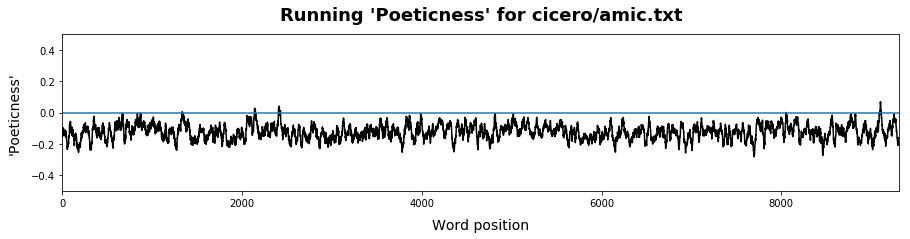

In [103]:
fileid = 'cicero/amic.txt'
tokens = get_lemmatized_text(preprocess(latinlibrary.raw(fileid))).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

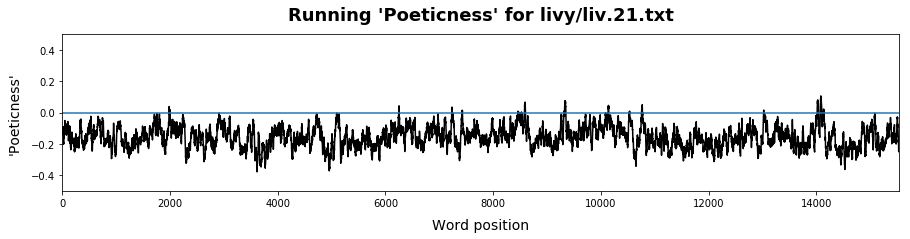

In [101]:
fileid = 'livy/liv.21.txt'
tokens = get_lemmatized_text(preprocess(latinlibrary.raw(fileid))).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

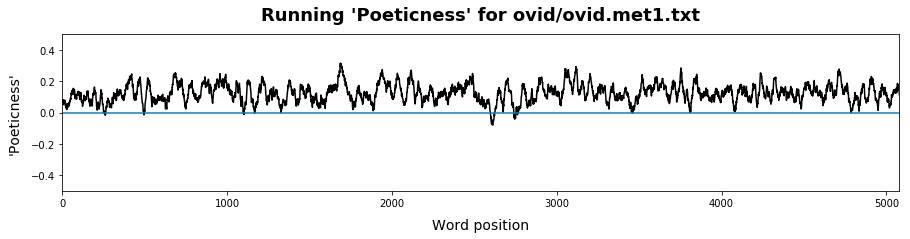

In [102]:
fileid = 'ovid/ovid.met1.txt'
tokens = get_lemmatized_text(preprocess(latinlibrary.raw(fileid))).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

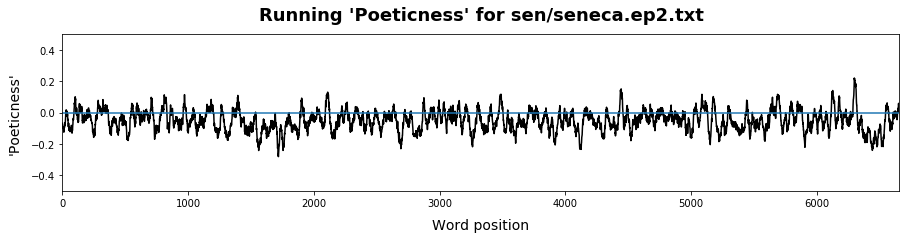

In [43]:
fileid = 'sen/seneca.ep2.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

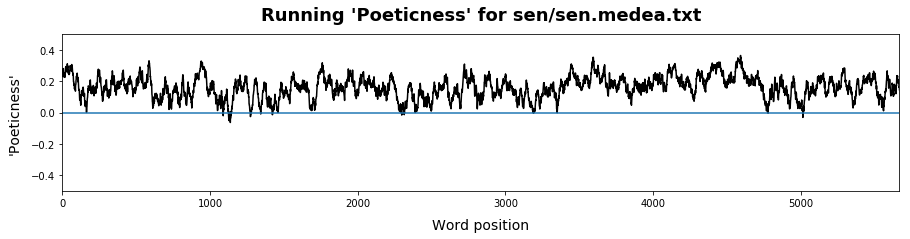

In [44]:
fileid = 'sen/sen.medea.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

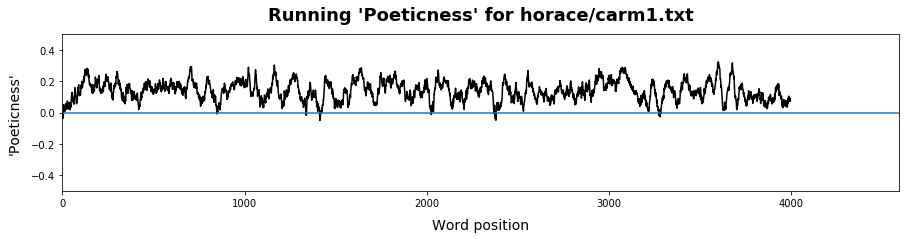

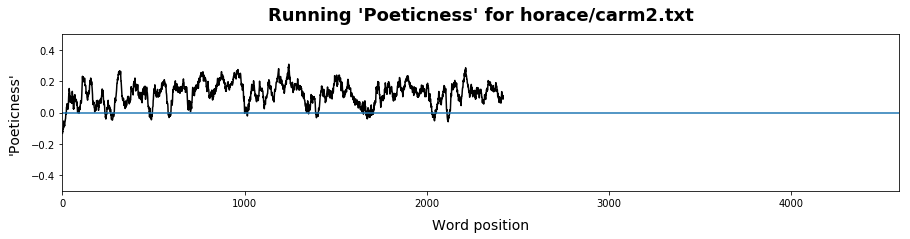

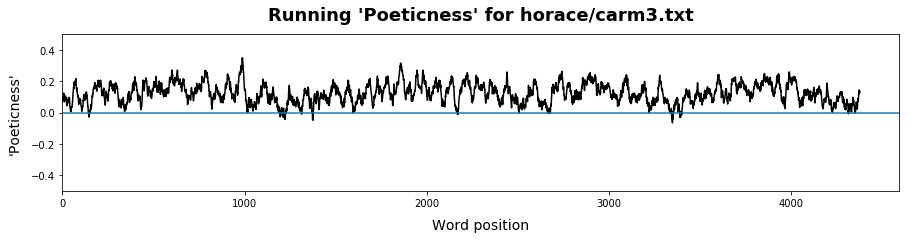

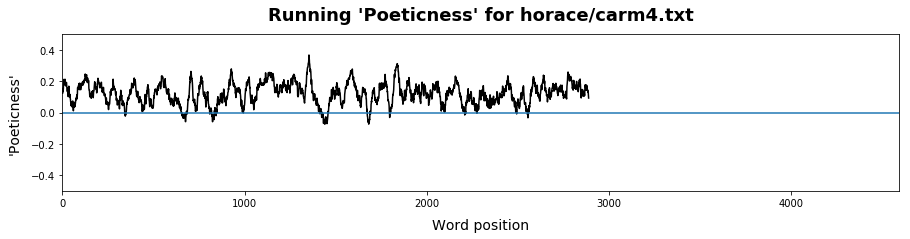

In [45]:
odes = [file for file in latinlibrary.fileids() if 'horace/carm' in file]
odes.remove('horace/carmsaec.txt')

length = max([len(latinlibrary.raw(text).split()) for text in odes])

for book in odes:
    tokens = preprocess(latinlibrary.raw(book)).split()
    running_scores = running_poeticness(tokens, 25)
    plot_running_poeticness(running_scores, book, length=length)

In [46]:
lucan = [file for file in latinlibrary.fileids() if 'lucan/' in file]
lucan = sorted(lucan, key=lambda x : int(" ".join(re.findall(r'\d+',x))))

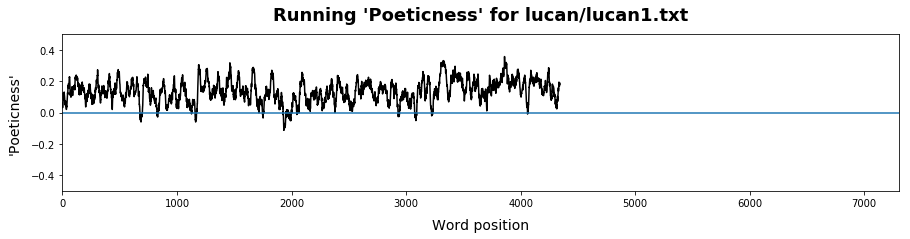

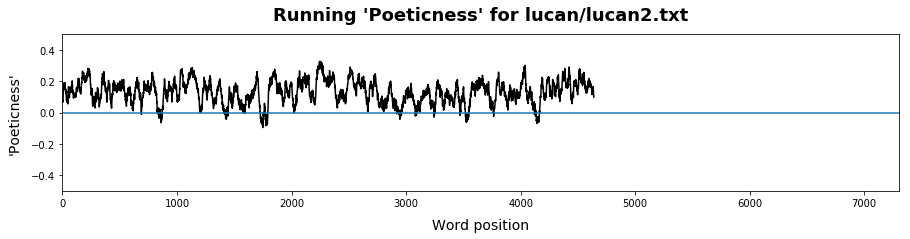

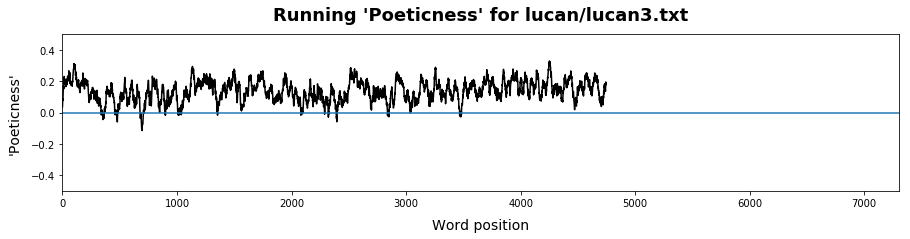

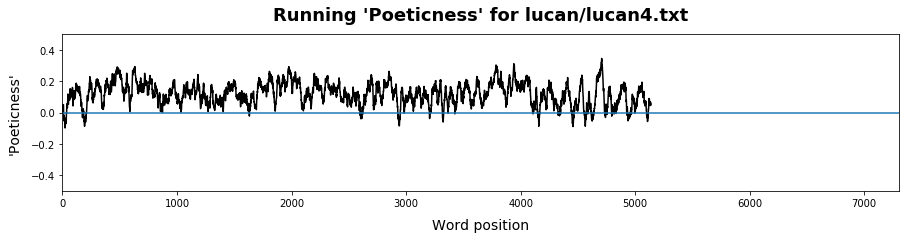

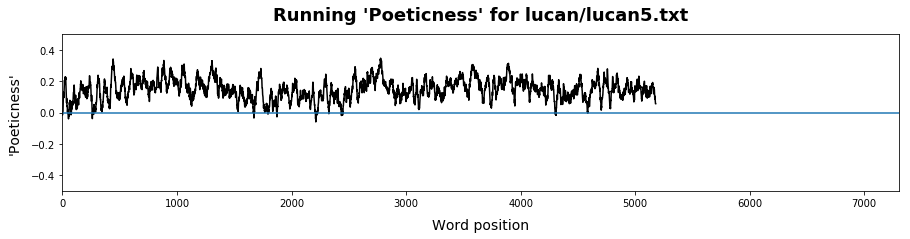

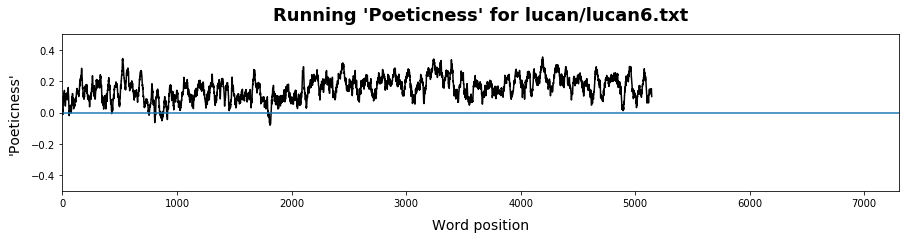

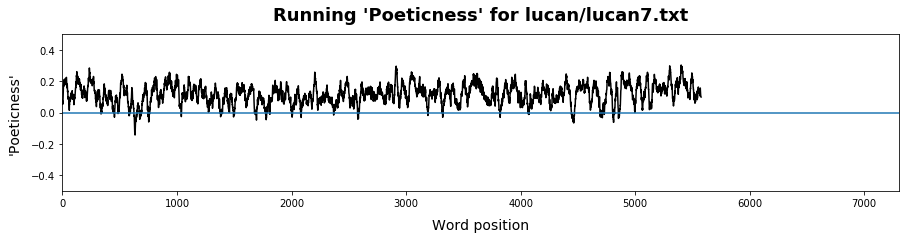

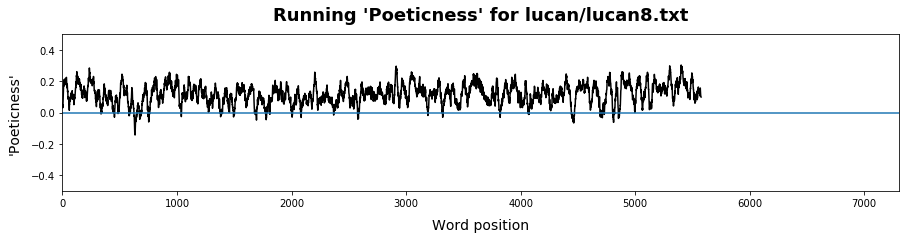

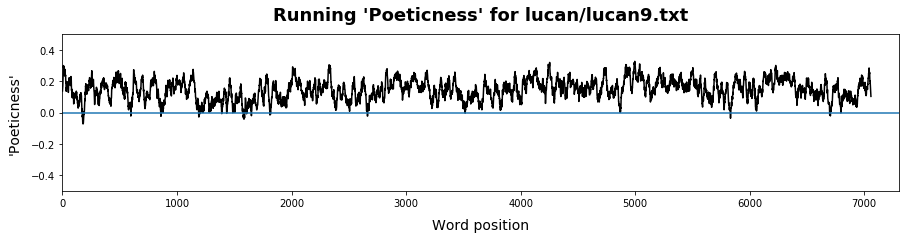

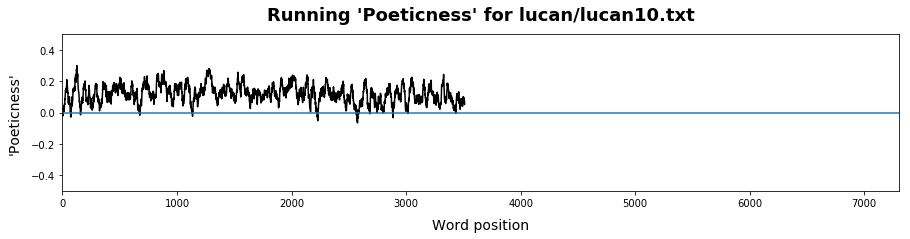

In [47]:
length = max([len(latinlibrary.raw(text).split()) for text in lucan])

for book in lucan:
    tokens = preprocess(latinlibrary.raw(book)).split()
    running_scores = running_poeticness(tokens, 25)
    plot_running_poeticness(running_scores, book, length=length)

## Neutral Words

In [104]:
type_df.loc['sol uir herba'.split()]

,prose,verse,poeticness,keyness_scaled
sol,199,329,0.623106,0.000868
uir,265,707,0.727366,0.000188
herba,39,225,0.852273,0.001653
